In [1]:
import torch
import falcor
import time
import numpy as np
import pyexr as exr
import sys
import os
import dataclasses
import datetime
import glob
import argparse

sys.path.append(os.path.join(os.path.abspath(''), ".."))
import common
import material_utils
from loss import compute_render_loss_L1, compute_render_loss_L2


In [1]:
import open3d as o3d

o3d.visualization.webrtc_server.enable_webrtc()
cube_red = o3d.geometry.TriangleMesh.create_box(1, 2, 4)
cube_red.compute_vertex_normals()
cube_red.paint_uniform_color((1.0, 0.0, 0.0))
o3d.visualization.draw(cube_red)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] WebRTC GUI backend enabled.


RuntimeError: [Open3D Error] (void __cdecl open3d::visualization::gui::Application::SetWindowSystem(class std::shared_ptr<class open3d::visualization::gui::WindowSystem>)) D:\a\Open3D\Open3D\cpp\open3d\visualization\gui\Application.cpp:344: Cannot set WindowSystem. It is already set.


In [2]:
device = torch.device("cuda:0")
print(device)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

cuda:0


D:\miniconda\envs\falcor-pytorch\lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [3]:
CUR_DIR = os.path.abspath('')
sys.path.append(os.path.join(CUR_DIR, ".."))
import common
width = 360
height = 410

output_dir = CUR_DIR + "/results/"
ref_scene_filepath = "test_scenes/cornell_box_bunny.pyscene"

device_id = 0
testbed = common.create_testbed([width, height])
device = testbed.device


# Load the reference scene.
ref_scene = common.load_scene(
    testbed,
    ref_scene_filepath,
    width / height,
)


ml_data = device.create_structured_buffer(
    struct_size = 12*4,
    element_count=width*height,
    bind_flags=falcor.ResourceBindFlags.ShaderResource  
    | falcor.ResourceBindFlags.UnorderedAccess
    | falcor.ResourceBindFlags.Shared
)
device.render_context.wait_for_falcor()

In [4]:
render_graph = testbed.create_render_graph("StandardPathTracer")

# Create the PathTracer pass.
path_tracer_pass = render_graph.create_pass(
    "PathTracer",
    "PathTracer",
    {
        "samplesPerPixel": 1, "useSER": False
    }
)

# Create the VBufferRT pass.
vbuffer_rt_pass = render_graph.create_pass(
    "VBufferRT",
    "VBufferRT",
    {
        "samplePattern": "Stratified",
        "sampleCount": 16,
        "useAlphaTest": True
    }
)

# Add edges to connect the passes.
render_graph.add_edge("VBufferRT.vbuffer", "PathTracer.vbuffer")
render_graph.add_edge("VBufferRT.viewW", "PathTracer.viewW")
render_graph.add_edge("VBufferRT.mvec", "PathTracer.mvec")

# Mark the output of the PathTracer pass.
render_graph.mark_output("PathTracer.color")

# Assign the configured render graph to the testbed.
testbed.render_graph = render_graph

path_tracer_pass.mlData = ml_data


In [5]:
testbed.frame()

In [6]:

img = testbed.render_graph.get_output("PathTracer.color").to_numpy()

In [7]:
import matplotlib.pyplot as plt 
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [8]:
def falcor_to_torch(buffer: falcor.Buffer, dtype=torch.float32):
    params = torch.tensor([0]*(buffer.element_count*12), dtype=dtype)
    buffer.copy_to_torch(params)
    device.render_context.wait_for_cuda()
    return params

In [9]:
def extract_field(data, start, struct_size, field_size):
    return torch.cat([data[i:i + field_size] for i in range(start, data.numel(), struct_size)])

def falcor_to_torch_split_interleaved(buffer, field_types, dtype=torch.float32):
    # Size mapping for different types (add more types if needed)
    size_mapping = {
        "float3": 3  # 3 floats in a float3
    }

    # Calculate the size of one complete set of fields
    struct_size = sum(size_mapping[field_type] for field_type in field_types.values())
    # Calculate the total size of the tensor
    total_size = struct_size * buffer.element_count    
    all_data = buffer.to_torch([total_size])
    device.render_context.wait_for_cuda()

    # Splitting the tensor into separate tensors for each field considering interleaved structure
    tensors = {}
    offset = 0
    for i, (field_name, field_type) in enumerate(field_types.items()):
        field_size  = size_mapping[field_type]
        field_start = i * field_size

        tensors[field_name] = extract_field(all_data, field_start, struct_size, field_size).reshape(-1, field_size)
                

    return tensors

# Example usage
field_types = {"radiance": "float3", "dir": "float3", "thp": "float3", "worldpos": "float3"}
mlDataOutput = falcor_to_torch_split_interleaved(ml_data, field_types)

In [10]:
def visualize_directional_data(tensor, sample_probability=1.0):
    """
    Visualize a tensor containing directional data.
    Assumes each row in the tensor represents a 3D vector.

    Args:
    tensor (torch.Tensor): A tensor of shape (n, 3) representing directional vectors.
    sample_probability (float): Probability of including each direction vector (0.0 to 1.0).
    """

    if tensor.shape[1] != 3:
        raise ValueError("Tensor must have shape (n, 3) where each row is a 3D vector.")
    
    if sample_probability < 0.0 or sample_probability > 1.0:
        raise ValueError("Sample probability must be between 0.0 and 1.0.")

    # Create a mask to randomly include directions based on sample_probability
    mask = np.random.uniform(0, 1, size=tensor.shape[0]) < sample_probability
    sampled_tensor = tensor[mask]

    # Normalize the sampled vectors
    magnitude = torch.norm(sampled_tensor, dim=1)
    normalized_tensor = torch.where(magnitude.unsqueeze(1) > 0, sampled_tensor / magnitude.unsqueeze(1), sampled_tensor)

    # Extracting x, y, z components for 3D plot
    x, y, z = normalized_tensor[:, 0].numpy(), normalized_tensor[:, 1].numpy(), normalized_tensor[:, 2].numpy()

    # 3D Visualization of Direction Vectors
    fig = plt.figure(figsize=(12, 5))

    # 3D plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.quiver(np.zeros_like(x), np.zeros_like(y), np.zeros_like(z), x, y, z)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Visualization of Direction Vectors')

    # Histogram of Vector Magnitudes
    ax2 = fig.add_subplot(122)
    ax2.hist(magnitude.numpy(), bins=100, range=(0, 2))
    ax2.set_xlabel('Magnitude')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Histogram of Vector Magnitudes')

    plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_normals_3d(directions, positions, sample_probability=1.0):
    """
    Visualize directional vectors at their corresponding world positions in 3D.

    Args:
    directions (torch.Tensor): A tensor of shape (n, 3) representing directional vectors.
    positions (torch.Tensor): A tensor of shape (n, 3) representing world positions.
    sample_probability (float): Probability of including each directional vector (0.0 to 1.0).
    """
    if directions.shape != positions.shape:
        raise ValueError("Directions and positions must have the same shape (n, 3).")

    if sample_probability < 0.0 or sample_probability > 1.0:
        raise ValueError("Sample probability must be between 0.0 and 1.0.")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Normalize directions
    magnitudes = torch.norm(directions, dim=1)
    directions = torch.where(magnitudes.unsqueeze(1) > 0, directions / magnitudes.unsqueeze(1), directions)

    # Determine which directions to include based on sample_probability
    sample_mask = torch.rand(directions.shape[0]) < sample_probability
    directions = directions[sample_mask].cpu()
    positions = positions[sample_mask].cpu()

    # Plot arrows for each direction at its corresponding position
    
    for i in range(directions.shape[0]):
        x, y, z = positions[i].numpy()
        u, v, w = directions[i].numpy()
        ax.quiver(x, y, z, u, v, w, length=0.01, normalize=True, color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Visualization of Normals at World Positions')
    plt.show()

# Example usage:
# visualize_normals_3d(mlDataOutput["dir"].cpu(), mlDataOutput["worldpos"].cpu())

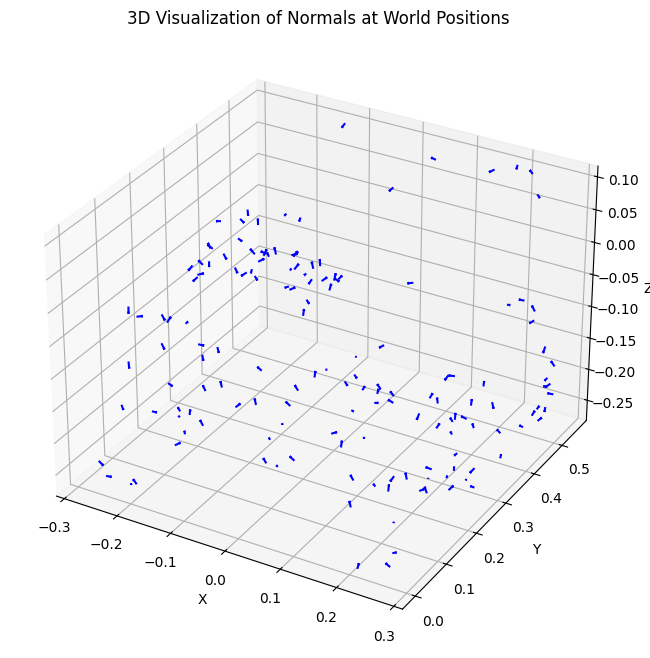

In [12]:
visualize_normals_3d(mlDataOutput["dir"], mlDataOutput["worldpos"], sample_probability=0.001)

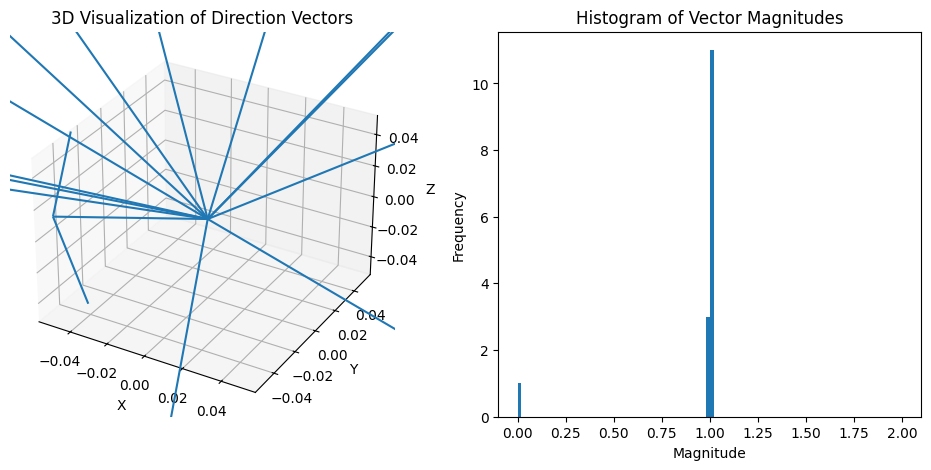

In [13]:
visualize_directional_data(mlDataOutput["dir"].cpu(), sample_probability=0.0001)

In [14]:
cols = range(mlDataOutput["thp"].shape[0])


In [15]:
import numpy as np
from vedo import Plotter, Spheres, settings

settings.default_backend = 'k3d'

# Generate 100 random positions
positions = np.random.rand(147600, 3)


thp = np.random.randint(0, 255, size=(147600, 3))

# Create a point cloud
point_cloud = Spheres(positions, r=0.005, c=thp)
plt = Plotter()
plt.show(point_cloud, "points")

D:\miniconda\envs\falcor-pytorch\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…

In [ ]:
plt.show(point_cloud, "points")

In [17]:
thp_real = mlDataOutput["thp"]
thp_real = (thp*255).int().cpu().numpy()
positions_real = positions.cpu().numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'int'

In [29]:
positions = mlDataOutput["worldpos"].cpu().numpy()+0.27500007


In [28]:
print(np.min(positions))

-0.27500007


In [ ]:
point_cloud = Spheres(positions, r=0.005, c=thp)
plt = Plotter()
plt.show(point_cloud, "points")

In [56]:
print(positions)

[[0.01872233 0.28984538 0.8070868 ]
 [0.08691311 0.72555946 0.59636523]
 [0.9666339  0.60124204 0.52268462]
 ...
 [0.96951365 0.44489053 0.46072579]
 [0.18028679 0.36706377 0.13611487]
 [0.68963901 0.32610499 0.17469701]]


In [60]:
positions = mlDataOutput["worldpos"].cpu().numpy()


In [22]:
from vedo import Plotter, Points, Arrows
from vedo import show, Spheres
from vedo import dataurl, Mesh, Plotter, Volume, settings

settings.default_backend = 'k3d'

# Assume mlDataOutput["worldpos"] and mlDataOutput["dir"] are your numpy arrays
positions = mlDataOutput["worldpos"]
directions = mlDataOutput["dir"]
thp = mlDataOutput["thp"]

thp = (thp*255).int()




In [37]:
positions_cpu = positions.cpu().numpy()
thp_cpu = thp.cpu().numpy()

In [55]:
positions_cpu.shape

(147600, 3)

In [50]:
thp_cpu.shape

(147600, 3)

In [48]:
positions_small = positions_cpu[:10000]
thp_small = thp_cpu[:10000]

In [49]:
# Create a point cloud and arrows
point_cloud = Spheres(positions_small, r=0.005, c=thp_small)
plt = Plotter()
plt.show(point_cloud, "points")

TraitError: colors has wrong size: 980000 (967554 required)

In [16]:

dirs_color = np.round(directions*255).numpy().astype(int)
arrows = Arrows(positions, directions*0.001+positions, shaft_radius=1, head_radius=1, thickness=1, c=dirs_color)

# Show the point cloud and arrows
plt.show(arrows, axes=0)

In [2]:
from vedo import dataurl, Mesh, Plotter, Volume, settings

settings.default_backend = 'k3d'

msh = Mesh(dataurl+"beethoven.ply").c('gold').subdivide()
plt = Plotter(bg='black')
plt.show(msh)

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], camera_…

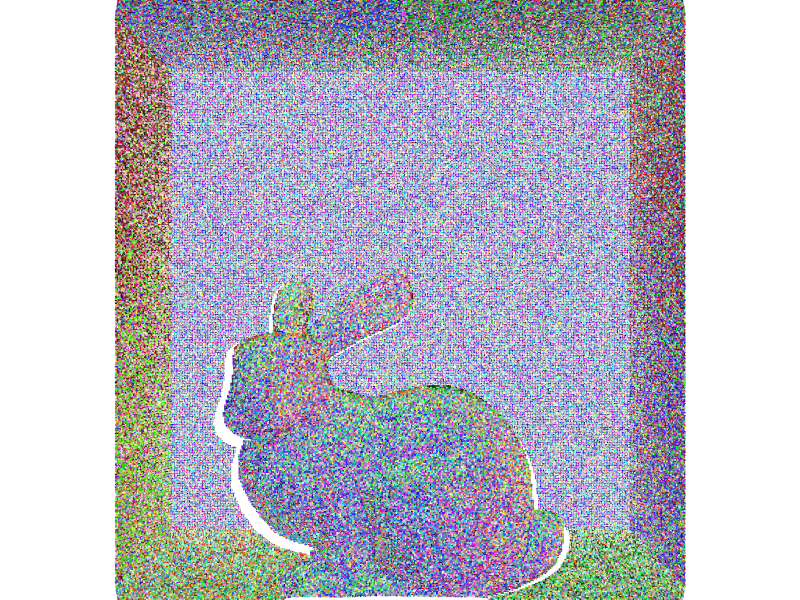

In [16]:
plt.show(arrows, axes=0)

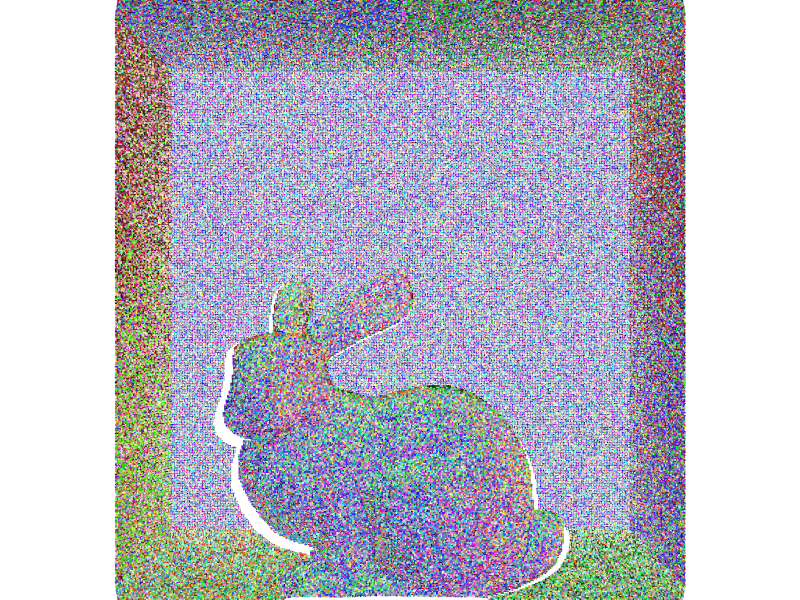

In [17]:
plt.fly_to([1,0,0])
show(arrows, axes=0, camera={'pos': (0, 0, 0)})


In [3]:
!pip install vedo

     ---------------------------------------- 0.0/4.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.8 MB 660.6 kB/s eta 0:00:08
     - -------------------------------------- 0.2/4.8 MB 2.5 MB/s eta 0:00:02
     ---- ----------------------------------- 0.5/4.8 MB 3.9 MB/s eta 0:00:02
     ------- -------------------------------- 0.9/4.8 MB 5.2 MB/s eta 0:00:01
     ---------- ----------------------------- 1.3/4.8 MB 6.0 MB/s eta 0:00:01
     -------------- ------------------------- 1.8/4.8 MB 6.7 MB/s eta 0:00:01
     ----------------- ---------------------- 2.1/4.8 MB 6.8 MB/s eta 0:00:01
     -------------------- ------------------- 2.4/4.8 MB 6.7 MB/s eta 0:00:01
     -------------------- ------------------- 2.5/4.8 MB 6.4 MB/s eta 0:00:01
     ------------------------ --------------- 2.9/4.8 MB 6.4 MB/s eta 0:00:01
     ------------------------- -------------- 3.1/4.8 MB 6.1 MB/s eta 0:00:01
     -------------------------- ------------- 3.2/4.8 MB 6.1 MB/s eta

In [6]:
from vedo import *
printc(__doc__, invert=1)

plt1 = Plotter(N=3, axes=1)

mesh = Mesh(dataurl+"bunny.obj").normalize().subdivide()

pts = mesh.vertices
pts += np.random.randn(len(pts), 3)/20  # add noise, will not mess up the original points


#################################### smooth cloud with MLS
# build the mesh points
s0 = Points(pts, r=3).color("blue")
plt1.at(0).show(s0, "original point cloud + noise")

# project s1 points into a smooth surface of points
# The parameter f controls the size of the local regression.
mls1 = s0.clone().smooth_mls_2d(f=0.5)
plt1.at(1).show(mls1, "MLS first pass, f=0.5")

# mls1 is an Assembly so unpack it to get the first object it contains
mls2 = mls1.clone().smooth_mls_2d(radius=0.1)
plt1.at(2).show(mls2, "MLS second pass, radius=0.1")


#################################### draw errors
plt2 = Plotter(pos=(300, 400), N=2, axes=1)

variances = mls2.pointdata["MLSVariance"]
vmin, vmax = np.min(variances), np.max(variances)
print("min and max of variances:", vmin, vmax)
vcols = [color_map(v, "jet", vmin, vmax) for v in variances]  # scalars->colors

sp0 = Spheres(mls2.vertices, c=vcols, r=0.02)         # error as color
sp1 = Spheres(mls2.vertices, c="red5", r=variances/4) # error as point size

mesh.color("k").alpha(0.05).wireframe()

plt2.at(0).show(sp0, "Use color to represent variance", interactive=True)
plt2.at(1).show(sp1, "point size to represent variance", zoom=1.3, interactive=True)


Automatically created module for IPython interactive environment
min and max of variances: 0.0 0.28928146


In [1]:
import open3d as o3d
mesh = o3d.geometry.TriangleMesh.create_sphere();
mesh.compute_vertex_normals();
o3d.visualization.draw(mesh, raw_mode=True) 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Window window_0 created.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.


KeyboardInterrupt: 

In [27]:
while True:
    testbed.frame()

KeyboardInterrupt: 

In [15]:
import open3d as o3d

# Create a PointCloud object
pcd = o3d.geometry.PointCloud()

# Set the points of the point cloud to the world positions
pcd.points = o3d.utility.Vector3dVector(mlDataOutput['worldpos'][0:100].cpu())

# Assuming 'dir' represents RGB colors, set the colors of the point cloud
# If 'dir' represents something else (like normals), this part will change
pcd.colors = o3d.utility.Vector3dVector(mlDataOutput['dir'][0:100].cpu())

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] GLFW Error: Win32: Failed to register window class: Class already exists. 
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [18]:
print(o3d.__version__)

0.17.0


In [19]:
import open3d as o3d
mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh.compute_vertex_normals()
o3d.visualization.draw(mesh, raw_mode=True)

[Open3D INFO] Window window_0 created.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.


KeyboardInterrupt: 

In [20]:
armadillo_mesh = o3d.data.ArmadilloMesh()
mesh = o3d.io.read_triangle_mesh(armadillo_mesh.path)

knot_mesh = o3d.data.KnotMesh()
mesh = o3d.io.read_triangle_mesh(knot_mesh.path)

[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/ArmadilloMesh.ply
[Open3D INFO] Downloaded to C:\Users\Mikhail Dereviannykh/open3d_data/download/ArmadilloMesh/ArmadilloMesh.ply
[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/KnotMesh.ply
[Open3D INFO] Downloaded to C:\Users\Mikhail Dereviannykh/open3d_data/download/KnotMesh/KnotMesh.ply


In [27]:
mlDataOutput = {
    'worldpos': np.random.rand(100, 3),  # Dummy data for positions (100 points)
    'dir': np.random.rand(100, 3)  # Dummy data for directions/colors (100 points)
}

# Create a PointCloud object
pcd = o3d.geometry.PointCloud()

# Set the points of the point cloud to the world positions
pcd.points = o3d.utility.Vector3dVector(mlDataOutput['worldpos'])

# Assuming 'dir' represents RGB colors, set the colors of the point cloud
# If 'dir' represents something else (like normals), this part will change
pcd.colors = o3d.utility.Vector3dVector(mlDataOutput['dir'])

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Win32: Failed to register window class: Class already exists. 
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [28]:
o3d.visualization.webrtc_server.enable_webrtc()


[Open3D INFO] WebRTC GUI backend enabled.


RuntimeError: [Open3D Error] (void __cdecl open3d::visualization::gui::Application::SetWindowSystem(class std::shared_ptr<class open3d::visualization::gui::WindowSystem>)) D:\a\Open3D\Open3D\cpp\open3d\visualization\gui\Application.cpp:344: Cannot set WindowSystem. It is already set.
